In [3]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np

In [4]:
cell_size = (1,1,0)

boundary_layer = [
    mp.PML(0.3, mp.X),
    mp.PML(0.3, mp.Y)
                  ]

In [5]:
resolution = 100
nfreq = 100

# 파장 범위 설정 (단위: μm)
lambda_min = 0.4002
lambda_max = 0.7005
# lambda_cen = 0.55

fmin = 1 / lambda_max
fmax = 1 / lambda_min
fcen = 0.5 * (fmin + fmax)

df = fmax - fmin

In [6]:
source_center = mp.Vector3(0,0,0)
sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ey,
    center=source_center,
    size=mp.Vector3(0,0)
)]

In [7]:
sim = mp.Simulation(
    cell_size=cell_size,
    default_material=mp.Medium(index=1),
    boundary_layers=boundary_layer,
    sources=sources,
    resolution=resolution
)

In [8]:
offset = 0.01
flux_size = 0.02
source_center = mp.Vector3(0,0,0)

box_power = sim.add_flux(
    fcen, df, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y
                ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

<Axes: xlabel='X', ylabel='Y'>

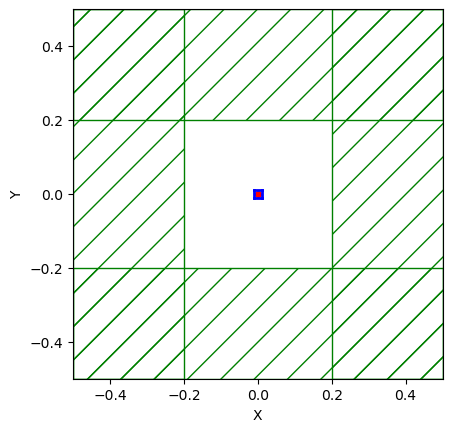

In [9]:
sim.plot2D()

on time step 50000 (time=250), 0.000619427 s/step
run 5 finished at t = 300.0 (60000 timesteps)
λ (μm)		net dipole power (W)
0.7005		5.244138e-06
0.6952		8.012187e-06
0.6900		1.221321e-05
0.6849		1.846470e-05
0.6799		2.758627e-05
0.6749		4.075022e-05
0.6700		5.964313e-05
0.6652		8.654606e-05
0.6605		1.243846e-04
0.6558		1.769299e-04
0.6511		2.492272e-04
0.6466		3.480635e-04
0.6421		4.822363e-04
0.6377		6.627111e-04
0.6333		9.030646e-04
0.6290		1.220382e-03
0.6247		1.636189e-03
0.6205		2.176850e-03
0.6164		2.873554e-03
0.6123		3.762670e-03
0.6083		4.886824e-03
0.6043		6.295889e-03
0.6004		8.046717e-03
0.5965		1.020176e-02
0.5927		1.282808e-02
0.5889		1.599746e-02
0.5852		1.978634e-02
0.5815		2.427344e-02
0.5779		2.953540e-02
0.5743		3.564298e-02
0.5707		4.265934e-02
0.5672		5.063859e-02
0.5638		5.962130e-02
0.5603		6.962734e-02
0.5570		8.065027e-02
0.5536		9.265592e-02
0.5503		1.055826e-01
0.5471		1.193384e-01
0.5439		1.337956e-01
0.5407		1.487884e-01
0.5375		1.641167e-01
0.5344		1.7955

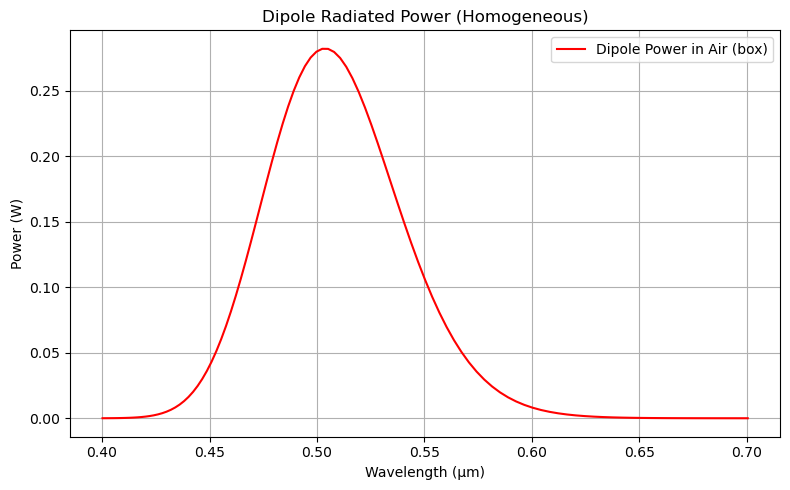

In [19]:
sim.init_sim()
# === 시뮬레이션 실행 ===
sim.run(until=50)
# sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, mp.Vector3(), 1e-8))

# === 측정된 flux 데이터 얻기 ===
flux_freqs = mp.get_flux_freqs(box_power)   # 측정된 주파수 배열 (1/μm)
net_power = mp.get_fluxes(box_power)        # 측정된 각 주파수의 dipole 방사 power (W)

# === 파장으로 변환 (μm)
wavelengths = 1 / np.array(flux_freqs)

# === 결과 출력 예시
print("λ (μm)\t\tnet dipole power (W)")
for i in range(nfreq):
    print(f"{wavelengths[i]:.4f}\t\t{net_power[i]:.6e}")

# === 시각화 (옵션)
plt.figure(figsize=(8,5))
plt.plot(wavelengths, net_power, label="Dipole Power in Air (box)", color = 'red')
plt.xlabel("Wavelength (μm)")
plt.ylabel("Power (W)")
plt.title("Dipole Radiated Power (Homogeneous)")
# plt.ylim([-3, 14])
# plt.xlim([,2])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


f (1/μm)	net dipole power (W)
1.4276		2.936470e-05
1.4384		4.305834e-05
1.4492		6.278443e-05
1.4600		9.058239e-05
1.4708		1.298240e-04
1.4817		1.841780e-04
1.4925		2.594241e-04
1.5033		3.618812e-04
1.5141		5.010806e-04
1.5249		6.874411e-04
1.5358		9.360593e-04
1.5466		1.263352e-03
1.5574		1.692222e-03
1.5682		2.247314e-03
1.5790		2.961778e-03
1.5899		3.870720e-03
1.6007		5.019693e-03
1.6115		6.455885e-03
1.6223		8.238348e-03
1.6331		1.042649e-02
1.6440		1.309189e-02
1.6548		1.630378e-02
1.6656		2.014218e-02
1.6764		2.468028e-02
1.6872		2.999851e-02
1.6981		3.616419e-02
1.7089		4.324598e-02
1.7197		5.129184e-02
1.7305		6.034322e-02
1.7413		7.041291e-02
1.7522		8.149838e-02
1.7630		9.356179e-02
1.7738		1.065417e-01
1.7846		1.203379e-01
1.7954		1.348206e-01
1.8063		1.498234e-01
1.8171		1.651483e-01
1.8279		1.805689e-01
1.8387		1.958308e-01
1.8495		2.106669e-01
1.8604		2.247903e-01
1.8712		2.379229e-01
1.8820		2.497791e-01
1.8928		2.601070e-01
1.9036		2.686603e-01
1.9145		2.752512e-01
1.92

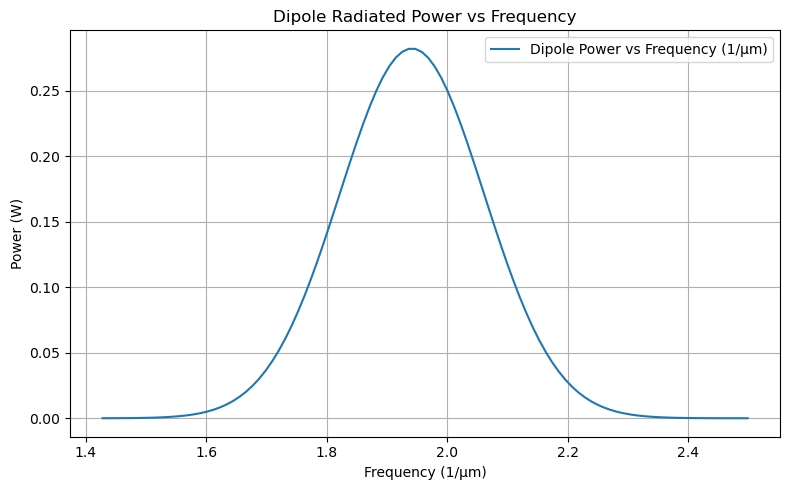

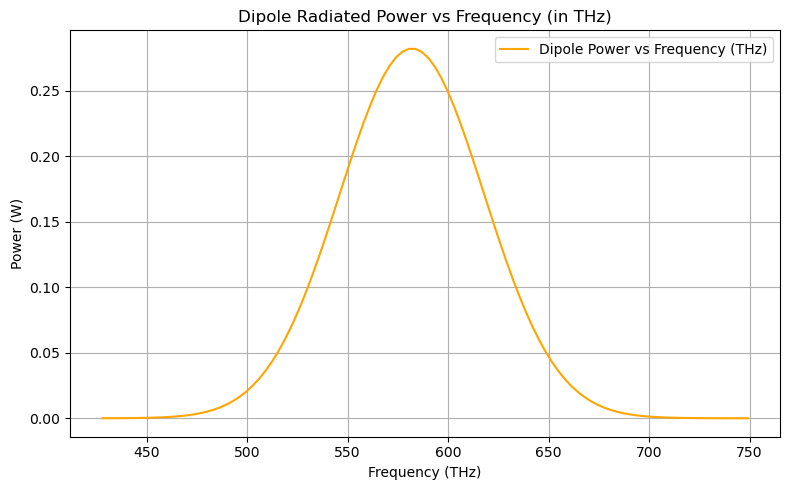

In [14]:
# === 주파수로 출력 (Meep 단위: 1/μm 기준)
print("f (1/μm)\tnet dipole power (W)")
for i in range(nfreq):
    print(f"{flux_freqs[i]:.4f}\t\t{net_power[i]:.6e}")

# === 만약 THz 단위로 보고 싶다면:
c0 = 299.792458  # (μm/fs) = speed of light
flux_freqs_THz = np.array(flux_freqs) * c0

print("\n=== Frequency in THz ===")
print("f (THz)\tnet dipole power (W)")
for i in range(nfreq):
    print(f"{flux_freqs_THz[i]:.2f}\t\t{net_power[i]:.6e}")

# === 주파수 기반 플롯 (1/μm 기준)
plt.figure(figsize=(8,5))
plt.plot(flux_freqs, net_power, label="Dipole Power vs Frequency (1/μm)")
plt.xlabel("Frequency (1/μm)")
plt.ylabel("Power (W)")
plt.title("Dipole Radiated Power vs Frequency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 주파수 기반 플롯 (THz 기준)
plt.figure(figsize=(8,5))
plt.plot(flux_freqs_THz, net_power, label="Dipole Power vs Frequency (THz)", color='orange')
plt.xlabel("Frequency (THz)")
plt.ylabel("Power (W)")
plt.title("Dipole Radiated Power vs Frequency (in THz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# === 파장 변환
wavelengths = 1 / np.array(flux_freqs)

# === 파장 기준으로 정렬
sorted_indices = np.argsort(wavelengths)
wavelengths = wavelengths[sorted_indices]
net_power = np.array(net_power)[sorted_indices]

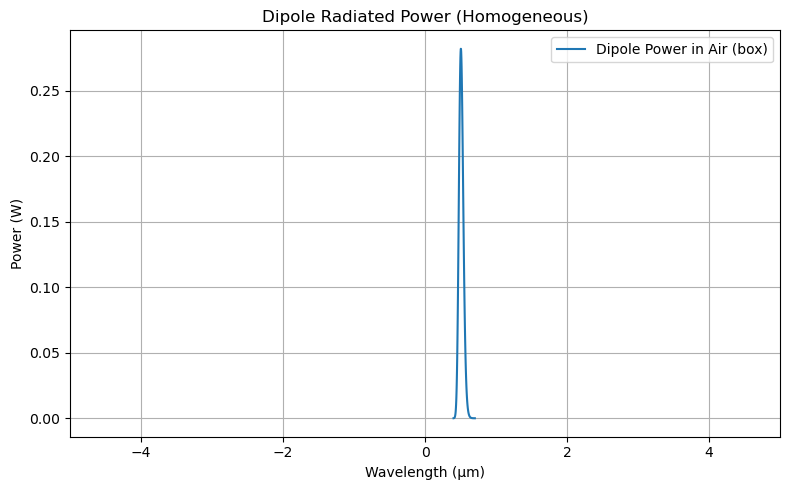

In [13]:
plt.figure(figsize=(8,5))
plt.plot(wavelengths, net_power, label="Dipole Power in Air (box)")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Power (W)")
plt.title("Dipole Radiated Power (Homogeneous)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xlim([-5, 5])
plt.show()